In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
data_train = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv')
data_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X_full = data_train.iloc[:,1:]
y_full = data_train.iloc[:,:1]
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size = 0.05)
x_train = x_train.values.reshape(-1, 1,28, 28).astype('float32') / 255.
x_test = x_test.values.reshape(-1, 1,28, 28).astype('float32') / 255.
y_train.label.unique()
np.bincount(y_train.label.values),np.bincount(y_test.label.values)

(array([5708, 5722, 5685, 5703, 5710, 5669, 5694, 5704, 5690, 5715]),
 array([292, 278, 315, 297, 290, 331, 306, 296, 310, 285]))

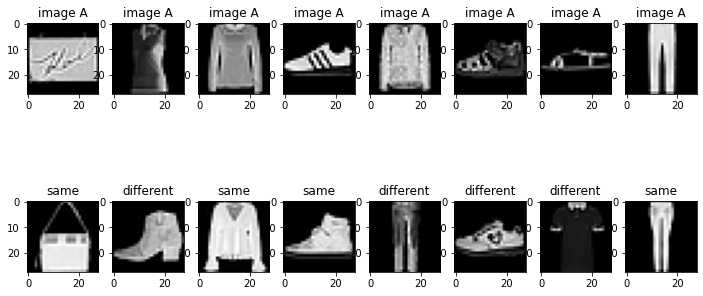

In [4]:
class mydataset(Dataset):
    def __init__(self,x_data,y_data):
        self.x_data = x_data
        self.y_data = y_data.label.values
    def __len__(self):
        return len(self.x_data)
    def __getitem__(self,idx):
        img1 = self.x_data[idx]
        y1 = self.y_data[idx]
        if np.random.rand() < 0.5:  
            idx2 = np.random.choice(np.arange(len(self.y_data))[self.y_data==y1],1)
        else:
            idx2 = np.random.choice(np.arange(len(self.y_data))[self.y_data!=y1],1)
        img2 = self.x_data[idx2[0]]
        y2 = self.y_data[idx2[0]]
        label = [0] if y1==y2 else [1]
        return torch.FloatTensor(img1),torch.FloatTensor(img2),torch.FloatTensor(label),y1
train_dataset = mydataset(x_train,y_train)
train_dataloader = DataLoader(dataset = train_dataset,batch_size=8)
val_dataset = mydataset(x_test,y_test)
val_dataloader = DataLoader(dataset = val_dataset,batch_size=8)
for idx,(img1,img2,target,_) in enumerate(train_dataloader):
    fig, axs = plt.subplots(2, img1.shape[0], figsize = (12, 6))
    for idx,(ax1,ax2) in enumerate(axs.T):
        ax1.imshow(img1[idx,0,:,:].numpy(),cmap='gray')
        ax1.set_title('image A')
        ax2.imshow(img2[idx,0,:,:].numpy(),cmap='gray')
        ax2.set_title('{}'.format('same' if target[idx,0]==0 else 'different'))
    break


In [5]:
class siamese(nn.Module):
    def __init__(self,z_dimensions=2):
        super(siamese,self).__init__()
        self.feature_net = nn.Sequential(
            nn.Conv2d(1,8,kernel_size=3,padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Conv2d(8,8,kernel_size=3,padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2),
            nn.Conv2d(8,16,kernel_size=3,padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,16,kernel_size=3,padding=1,stride=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.Conv2d(16,1,kernel_size=3,padding=1,stride=1),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(49,49)
        self.linear2 = nn.Linear(49,z_dimensions)
    def forward(self,x):
        x = self.feature_net(x)
        x = x.view(x.shape[0],-1)
        x = self.linear1(x)
        x = self.linear2(x)
        return x
model = siamese(z_dimensions=8).to(device)
# model.load_state_dict(torch.load('../working/saimese.pth'))
optimizor = torch.optim.Adam(model.parameters(),lr=0.001)
def contrastive_loss(pred1,pred2,target):
    MARGIN = 2
    euclidean_dis = F.pairwise_distance(pred1,pred2)
    target = target.view(-1)
    loss = (1-target)*torch.pow(euclidean_dis,2) + target * torch.pow(torch.clamp(MARGIN-euclidean_dis,min=0),2)
    loss = torch.mean(loss)
    return loss


In [6]:
train_dataset = mydataset(x_train,y_train)
train_dataloader = DataLoader(dataset = train_dataset,batch_size=128)
val_dataset = mydataset(x_test,y_test)
val_dataloader = DataLoader(dataset = val_dataset,batch_size=128)

In [7]:
for e in range(50):
    history = []
    for idx,(img1,img2,target,_) in enumerate(train_dataloader):
        img1 = img1.to(device)
        img2 = img2.to(device)
        target = target.to(device)
        
        pred1 = model(img1)
        pred2 = model(img2)
        loss = contrastive_loss(pred1,pred2,target)

        optimizor.zero_grad()
        loss.backward()
        optimizor.step()
        
        loss = loss.detach().cpu().numpy()
        history.append(loss)
        train_loss = np.mean(history)
    history = []
    with torch.no_grad():
        for idx,(img1,img2,target,_) in enumerate(val_dataloader):
            img1 = img1.to(device)
            img2 = img2.to(device)
            target = target.to(device)

            pred1 = model(img1)
            pred2 = model(img2)
            loss = contrastive_loss(pred1,pred2,target)

            loss = loss.detach().cpu().numpy()
            history.append(loss)
            val_loss = np.mean(history)
    print(f'train_loss:{train_loss},val_loss:{val_loss}')

train_loss:0.44767141342163086,val_loss:0.39460811018943787
train_loss:0.3712421655654907,val_loss:0.37207356095314026
train_loss:0.3467434048652649,val_loss:0.35477280616760254
train_loss:0.33548733592033386,val_loss:0.3605072498321533
train_loss:0.3295794427394867,val_loss:0.3368884027004242
train_loss:0.32469823956489563,val_loss:0.33623433113098145
train_loss:0.32066503167152405,val_loss:0.32756832242012024
train_loss:0.31792089343070984,val_loss:0.32642754912376404
train_loss:0.31093963980674744,val_loss:0.31706729531288147
train_loss:0.3059001564979553,val_loss:0.3284163475036621
train_loss:0.3074841797351837,val_loss:0.3203318417072296
train_loss:0.3003431260585785,val_loss:0.309444785118103
train_loss:0.2982446551322937,val_loss:0.3299310505390167
train_loss:0.29803141951560974,val_loss:0.3151080906391144
train_loss:0.29719826579093933,val_loss:0.32319945096969604
train_loss:0.29693248867988586,val_loss:0.3179965317249298
train_loss:0.29596900939941406,val_loss:0.30388864874839

In [8]:
torch.save(model.state_dict(),'saimese.pth')

In [9]:
x = [];y = [];
with torch.no_grad():
    for idx,(img1,img2,target,y1) in enumerate(val_dataloader):
        img1 = img1.to(device)
        img2 = img2.to(device)
        target = target.to(device)

        pred1 = model(img1)
        pred2 = model(img2)
        loss = contrastive_loss(pred1,pred2,target)

        x.append(pred1.detach().cpu().numpy())
        y.append(y1.detach().cpu().numpy())


In [10]:
X = np.concatenate(x,axis=0)
y = np.concatenate(y,axis=0)
y = y.reshape(-1)

Org data dimension is 8.       Embedded data dimension is 2


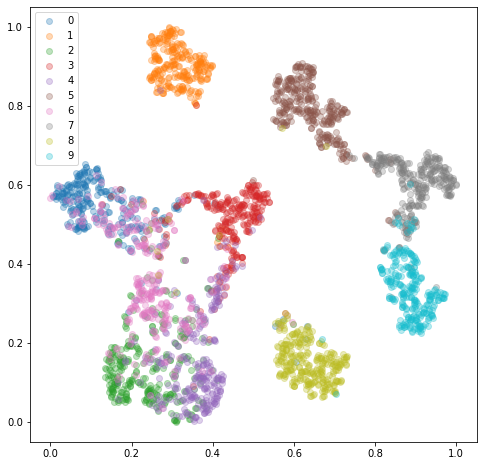

In [11]:
from sklearn import manifold
'''X是特征，不包含target;X_tsne是已经降维之后的特征'''
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)
print("Org data dimension is {}. \
      Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))
      
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
plt.figure(figsize=(8, 8))
for i in range(10):
    plt.scatter(X_norm[y==i][:,0],X_norm[y==i][:,1],alpha=0.3,label=f'{i}')
plt.legend()